In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from lmfit import Model

plt.style.use("ggplot")

# Regression issues

In [2]:
def linear_model(x, slope=1, intcpt=1):
    """Fit y = mx + c + ε"""
    return slope * x + intcpt


def power_law_model(x, A=1, n=1):
    """Fit y = Ax^n + ε"""
    return A * (x**n)


def print_ci(fit, y):
    """Print the best model params and 2-sigma (~95%) CI"""
    for key in fit.params.valuesdict().keys():
        val = fit.params[key].value
        ci_95 = 2*fit.params[key].stderr    
        print(f"{key}: {val:8.2f} ± {ci_95:6.2f}")
    r2 = 1 - fit.residual.var() / np.var(y)
    print(f"R2: {r2:.4f}")

## 1. Generate random data

Data for `BOF` and `TOC` generated below are completely random i.e. there is **no relationship between them** whatsoever.

In [3]:
# Build random, uncorrelated data for BOF and TOC
np.random.seed(17) # For reproducibility
size = 200
bof = np.random.uniform(low=0, high=1000, size=size)
toc = np.random.uniform(low=0, high=1800, size=size)
df = pd.DataFrame({"BOF": bof, "TOC": toc})
df = df.sort_values("BOF").reset_index(drop=True)
df.head()

,BOF,TOC
0,13.715933,1646.604387
1,15.696193,1006.920987
2,15.715232,752.270468
3,29.156997,877.717671
4,36.969148,1434.510680


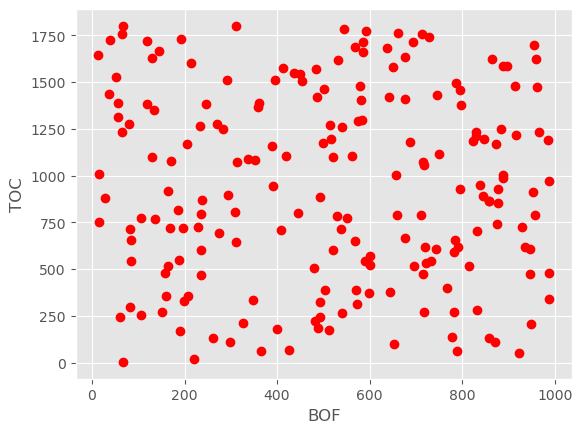

In [4]:
# Plot
plt.plot(df["BOF"], df["TOC"], "ro")
plt.xlabel("BOF")
plt.ylabel("TOC");

## 2. Simple linear model

Fit 

$$TOC = m * BOF + c + \epsilon$$

where $\epsilon$ is iid Gaussian noise.

slope:    -0.03 ±   0.25
intcpt:   955.90 ± 147.33
R2: 0.0004


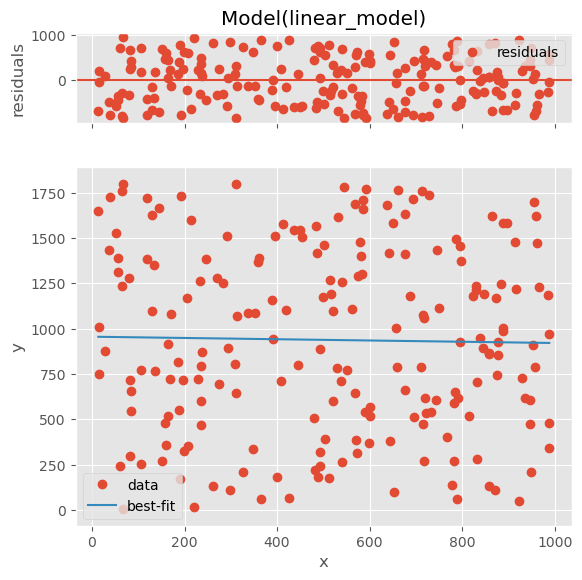

In [5]:
# Fit a linear model
model = Model(linear_model, independent_vars=["x"])
fit = model.fit(df["TOC"], x=df["BOF"])
fit.plot()
print_ci(fit, df["TOC"])

The slope is not significnatly different from zero i.e. the best model is the "null model" that ignores `x` completely and just predicts the mean of `y` for all values of `x`. The constant is estimated at `955.90 ± 147.33` and $R^2$ is zero.

## 3. Fit a power law

Fit the same data with a power law

$$TOC = A*BOF^n + \epsilon$$

where $\epsilon$ is iid Gaussian noise.

A:  1149.32 ± 561.89
n:    -0.03 ±   0.08
R2: 0.0032


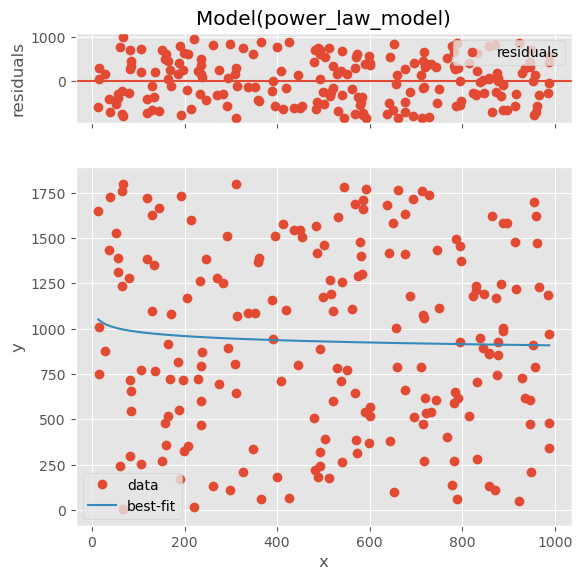

In [6]:
model = Model(power_law_model, independent_vars=["x"])
fit = model.fit(df["TOC"], x=df["BOF"])
fit.plot()
print_ci(fit, df["TOC"])

This result is consistent with the linear model: `n` is not significantly different from zero, so the "best" model is the null model that just predicts a constant. The constant in this case is estimated as `1149.32 ± 561.89` and $R^2$ is zero. Within the specified uncertainly bounds, this is consistent with the result from the linear model.

Neither the linear model nor the power law identify a relationship between TOC and BOF in these examples. This is correct, because the data are completely random. 

## 4. Fit a power law, but with `y` as an explicit function of `x`

This time we use a power law to predict the ratio TOC:BOF, instead of TOC. This is problematic because `y` is now an explicit function of `x`; we're essentially plotting $\frac{1}{x}$ against $x$, with some extra noise added from the random TOC data. The model is

$$\frac{TOC}{BOF} = A*BOF^n + \epsilon$$

where $\epsilon$ is iid Gaussian noise.

A:  1590.12 ± 357.81
n:    -1.10 ±   0.07
R2: 0.9999


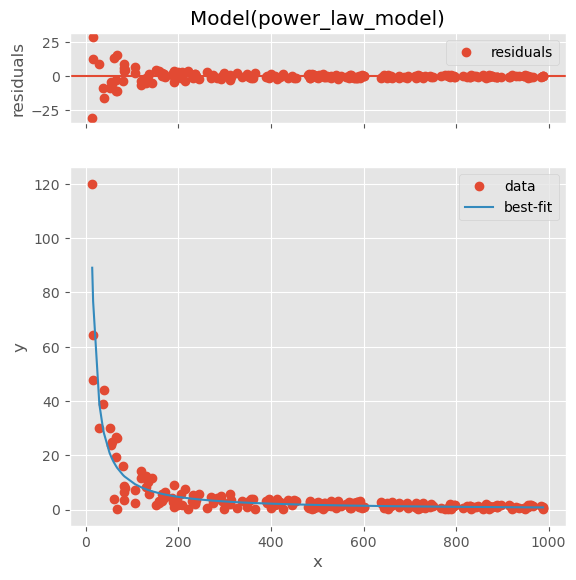

In [7]:
ratio = df["TOC"] / df["BOF"]

model = Model(power_law_model, independent_vars=["x"])
fit = model.fit(ratio, x=df["BOF"])
fit.plot()
print_ci(fit, df["TOC"])

Both parameters in this model are now highly significant ($p \ll 0$) and $R^2$ is essentially 1. However, any "significance" here is entirely due to regressing $\frac{1}{x}$ against $x$, because we know for certain there is no relationship between TOC and BOF in this dataset. 

The best fitting model based on this output is 

$$\frac{TOC}{BOF} = 1590*BOF^{-1.1}$$

(note that $n \approx -1 \rightarrow \frac{1}{x}$). If we rearrange this, we get

$$TOC = 1590*BOF^{-0.1}$$

This implies a relationship where none exists: in fact, `n` should be zero and `A` should be about 1000 (i.e. the "null model" identified by the other approaches above). Let's plot this on the raw data to see what it looks like.

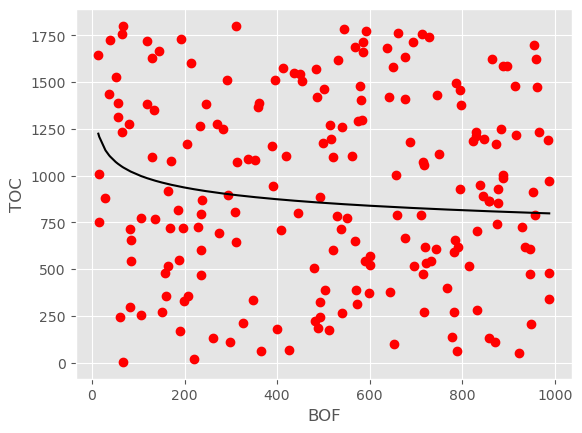

In [8]:
# Plot
preds = 1590*(df["BOF"]**-0.1)
plt.plot(df["BOF"], df["TOC"], "ro")
plt.plot(df["BOF"], preds, "k-")
plt.xlabel("BOF")
plt.ylabel("TOC");